In [3]:
import pandas as pd
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
data = pd.read_csv("data/melbourne/melbourne.csv")

In [8]:
# read sensor_location
sensor_location = pd.read_csv("data/melbourne/melbourne_sensor_locations.csv")
# merge data and sensor_location
merged_data = pd.merge(data, sensor_location, on="Location_ID", how="left")
# sort value by sensing_time
merged_data[merged_data["Location_ID"] == 19].sort_values(by="Sensing_Time", ascending=True)
# the maximum value of Direction_1

# check if some data's location_id is not in sensor_location
sensor_location[~sensor_location["Location_ID"].isin(data["Location_ID"])]

# filter the sensor location with Location_Type = "Outdoor"
sensor_location =  sensor_location[sensor_location["Location_Type"] == "Outdoor"]

# remove the isolate sensor, far away sensor
far_location_id = [180, 103, 85, 76]
sensor_location = sensor_location[~sensor_location["Location_ID"].isin(far_location_id)]


In [5]:
from shapely.geometry import Point, LineString
import folium
# Calculate center point for map initialization
center_lat = sensor_location['Latitude'].mean()
center_lon = sensor_location['Longitude'].mean()

buffer = 0.0001
north = sensor_location['Latitude'].max() + buffer # Add a small buffer
south = sensor_location['Latitude'].min() - buffer
east = sensor_location['Longitude'].max() + buffer
west = sensor_location['Longitude'].min() - buffer

# Download the road network (e.g., drivable roads)
# This can take time and download significant data
print("Downloading road network graph...")
# graph = ox.graph_from_bbox((north, south, east, west), network_type="walk")
# graph = ox.graph_from_place("Melbourne, Australia", network_type="walk", simplify=True)
# Then simplify with a custom tolerance (in meters)
graph = ox.graph_from_place("Melbourne, Australia", network_type="walk", 
                           custom_filter='["highway"~"primary|secondary|tertiary"]', simplify=True)

# graph = ox.graph_from_place("Melbourne, Australia", network_type="walk", 
#                            custom_filter='["highway"="cycleway"]', 
#                            simplify=True)

In [6]:

nodes, edges = ox.graph_to_gdfs(graph)
# filter the nodes
filtered_nodes = nodes[(nodes['y'] <= north) & (nodes['y'] >= south) &
                        (nodes['x'] <= east) & (nodes['x'] >= west)]
edges['u'] = edges.index.get_level_values(0)  # First level of the index
edges['v'] = edges.index.get_level_values(1)  # Second level of the index
filtered_edges = edges[edges['u'].isin(filtered_nodes.index) & edges['v'].isin(filtered_nodes.index)]

# reset the index
graph_filtered = ox.graph_from_gdfs(filtered_nodes, filtered_edges)
print(f"Original number of nodes: {len(graph_filtered.nodes)}")
def calculate_distance(point1, point2):
    return point1.distance(point2) * 111000  # Convert degrees to 
# Set threshold (adjust this value based on your needs)
distance_threshold = 30  # meters
nodes_to_remove = set()
n = 0
# Iterate through nodes
for idx1, row1 in filtered_nodes.iterrows():
    if idx1 in nodes_to_remove:
        continue
    for idx2, row2 in filtered_nodes.iterrows():
        if idx1 != idx2 and idx2 not in nodes_to_remove:
            distance = calculate_distance(row1.geometry, row2.geometry)
            if distance < distance_threshold:
                # print(distance)
                n += 1
                # Before removing node2, get its neighbors
                neighbors = list(graph_filtered.neighbors(idx2))
                # Add edges between node1 and all neighbors of node2
                for neighbor in neighbors:
                    if neighbor != idx1 and not graph_filtered.has_edge(idx1, neighbor):
                        # 1. Get attributes from the original edge to preserve them
                        attrs = graph_filtered.get_edge_data(idx2, neighbor, 0).copy()

                        # 2. Create new geometry and calculate new length
                        line = LineString([row1.geometry, filtered_nodes.loc[neighbor].geometry])
                        new_length = calculate_distance(row1.geometry, filtered_nodes.loc[neighbor].geometry)

                        # 3. Update attributes for the new edge
                        attrs['geometry'] = line
                        attrs['length'] = new_length
                        
                        # 4. Add the new edge with all attributes
                        graph_filtered.add_edge(idx1, neighbor, **attrs)

                        # 5. Do the same for the reverse edge if it exists
                        if graph_filtered.has_edge(neighbor, idx2):
                            rev_attrs = graph_filtered.get_edge_data(neighbor, idx2, 0).copy()
                            rev_attrs['geometry'] = line
                            rev_attrs['length'] = new_length
                            graph_filtered.add_edge(neighbor, idx1, **rev_attrs)

                nodes_to_remove.add(idx2)


# Remove the identified nodes
graph_filtered.remove_nodes_from(nodes_to_remove)
# remove the nodes that have no edges
graph_filtered.remove_nodes_from(list(nx.isolates(graph_filtered)))
largest_cc = max(nx.strongly_connected_components(graph_filtered), key=len)
nodes_to_remove = nodes_to_remove.union(set(graph_filtered.nodes()) - set(largest_cc))
graph_filtered.remove_nodes_from(nodes_to_remove)
print(f"Number of nodes removed: {len(nodes_to_remove)}")
print(f"Remaining nodes: {len(graph_filtered.nodes)}")


# Create a new index mapping for nodes
mapping = {old_id: new_id for new_id, old_id in enumerate(graph_filtered.nodes())}
graph_relabeled = nx.relabel_nodes(graph_filtered, mapping)
pos = {}
for node in graph_relabeled.nodes():
    # Get the original node ID using the reverse mapping
    original_node = list(mapping.keys())[list(mapping.values()).index(node)]
    pos[node] = (graph_filtered.nodes[original_node]['x'], graph_filtered.nodes[original_node]['y'])



Original number of nodes: 844
Number of nodes removed: 501
Remaining nodes: 341


In [7]:
# calculate the area of the nodes
# Assuming pos is your dictionary of node positions {node_id: (x, y)}
lats = [pos[1] for pos in pos.values()]
lons = [pos[0] for pos in pos.values()]

# Calculate the bounding box
min_lat, max_lat = min(lats), max(lats)
min_lon, max_lon = min(lons), max(lons)

# Calculate dimensions in degrees
lat_range = max_lat - min_lat
lon_range = max_lon - min_lon

# Convert to approximate kilometers (rough approximation)
# 1 degree latitude ≈ 111 km
# 1 degree longitude ≈ 111 km * cos(latitude)
avg_lat = (max_lat + min_lat) / 2  # use average latitude for longitude conversion
area_km2 = lat_range * 111 * lon_range * 111 * np.cos(np.radians(avg_lat))

print(f"Bounding box dimensions:")
print(f"Latitude range: {lat_range:.6f}° ({lat_range * 111:.2f} km)")
print(f"Longitude range: {lon_range:.6f}° ({lon_range * 111 * np.cos(np.radians(avg_lat)):.2f} km)")
print(f"Approximate area: {area_km2:.2f} km²")

Bounding box dimensions:
Latitude range: 0.028950° (3.21 km)
Longitude range: 0.035065° (3.07 km)
Approximate area: 9.88 km²


In [8]:


# Get the adjacency matrix of renamed graph
adj_matrix_renamed = nx.adjacency_matrix(graph_relabeled).todense()
# Save the mapping if needed for future reference
# mapping_df = pd.DataFrame.from_dict(mapping, orient='index', columns=['new_id'])
print("\nFirst few entries of the node mapping:")
# print(mapping_df.head())
is_symmetric = np.allclose(adj_matrix_renamed, adj_matrix_renamed.T)
print(f"Is adjacency matrix symmetric? {is_symmetric}")


First few entries of the node mapping:
Is adjacency matrix symmetric? True


In [9]:
# visualize the network
m = folium.Map(location=[center_lat, center_lon], zoom_start=14)
for idx, row in sensor_location.iterrows():
    # Original sensor location (blue)
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Sensor ID: {row['Location_ID']}",
        tooltip=f"Original Sensor: {row['Location_ID']}",
    ).add_to(m)

nodes, edges = ox.graph_to_gdfs(graph_relabeled)
for idx, row in nodes.iterrows():
    # Add marker for nearest node (red)
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        tooltip=f"Node ID: {idx}",  # Show the actual node ID (idx)
        radius=3,
        color="red",
        fill=True,
        fillOpacity=0.7
    ).add_to(m)

# Add edges to the map

for _, row in edges.iterrows():
    coords = [(y, x) for x, y in row["geometry"].coords]
    folium.PolyLine(coords, color="blue", weight=2).add_to(m)
m

In [10]:
# get the adjacency matrix and position of nodes of the simpilified graph
adjacency_matrix = nx.adjacency_matrix(graph_relabeled).todense()
# extract the edge distance
edge_distances = nx.get_edge_attributes(graph_relabeled, 'length')
edge_widths = nx.get_edge_attributes(graph_relabeled, 'width')
# Print some statistics
print(f"Number of nodes: {graph_relabeled.number_of_nodes()}")
print(f"Number of edges: {graph_relabeled.number_of_edges()}")

Number of nodes: 341
Number of edges: 942


In [11]:
import osmnx as ox
import networkx as nx

def get_node_distance(graph, node1_id, node2_id):
    """Get shortest path distance between two nodes in meters"""
    try:
        # Get shortest path distance using length attribute
        distance = nx.shortest_path_length(
            graph, 
            node1_id, 
            node2_id, 
            weight='length'
        )
        return distance
    except nx.NetworkXNoPath:
        return float('inf')  # No path exists

# Example usage:
# graph = ox.graph_from_place("Melbourne, Australia", network_type="walk")
distance = get_node_distance(graph_relabeled, 265, 286)
distance

254.04420840406038

In [12]:
# Clean up edge distances dictionary
processed_edge_distances = {(start, end): dist for (start, end, _), dist in edge_distances.items()}
processed_edge_width = {(start, end): width for (start, end, _), width in edge_widths.items()}
# Using Pickle
import pickle

# Save
with open("data/melbourne/edge_distances.pkl", 'wb') as f:  # Note: 'wb' for binary write
    pickle.dump(processed_edge_distances, f)


In [13]:
# JSON approach
import json

# Saving
with open("data/melbourne/node_positions.json", 'w') as f:
    json.dump({str(k): list(v) for k, v in pos.items()}, f)

# Loading
with open("data/melbourne/node_positions.json", 'r') as f:
    pos = {int(k): tuple(v) for k, v in json.load(f).items()}

import numpy as np
# Convert sparse matrix to dense numpy array and ensure float type
adj_matrix = nx.adjacency_matrix(graph_relabeled)  # Get sparse matrix
adj_matrix = adj_matrix.todense()  # Convert to dense matrix
adj_matrix = np.array(adj_matrix, dtype=float)  # Convert to numpy array with float type
# check if all elements are not greater than 1, if so, set to 1
adj_matrix[adj_matrix > 1] = 1
# diagnal matrix set to 0
np.fill_diagonal(adj_matrix, 0)


# Save the adjacency matrix
np.save("data/melbourne/adj_matrix.npy", adj_matrix)
# Load it back
adj_matrix_loaded = np.load("data/melbourne/adj_matrix.npy", allow_pickle=False)

# Verify the loading worked correctly
print(f"Matrix shape: {adj_matrix_loaded.shape}")
print(f"Are matrices identical? {np.array_equal(adj_matrix, adj_matrix_loaded)}")

Matrix shape: (341, 341)
Are matrices identical? True


In [12]:
from handlers.output_handler import OutputHandler
from src.utils.visualizer import NetworkVisualizer
import os
import json
import numpy as np

output_dir = os.path.join(".", "outputs")
# Load and analyze results
# simulation_dir = "/Users/mmai/Devs/Crowd-Control/outputs/sim_20250118_124616"  # Replace with actual timestamp

# data = OutputHandler.load_simulation(simulation_dir)
with open("data/melbourne/node_positions.json", 'r') as f:
    pos = {str(k): np.array(v) for k, v in json.load(f).items()}

In [13]:
# match the sensor location with the node id
# Find nearest nodes for each sensor
sensor_node_matches = []
for _, sensor in sensor_location.iterrows():
    nearest_node = ox.nearest_nodes(
        graph_relabeled, 
        X=sensor['Longitude'], 
        Y=sensor['Latitude']
    )
    sensor_node_matches.append({
        'sensor_id': sensor['Location_ID'],
        'node_id': nearest_node,
        'latitude': sensor['Latitude'],
        'longitude': sensor['Longitude']
    })

# Create DataFrame of sensor-node matches
sensor_node_df = pd.DataFrame(sensor_node_matches)
# save the sensor_node_df
# sensor_node_df.to_csv("data/melbourne/sensor_node_df.csv", index=False)
#load the sensor_node_df
# sensor_node_df = pd.read_csv("data/melbourne/sensor_node_df.csv")


# Load Simulation

In [52]:
from handlers.output_handler import OutputHandler
from src.utils.visualizer import NetworkVisualizer
import os
import json
import numpy as np

output_dir = os.path.join(".", "outputs")
# data = OutputHandler.load_simulation(simulation_dir)
with open("data/melbourne/node_positions.json", 'r') as f:
    pos = {str(k): np.array(v) for k, v in json.load(f).items()}

/Users/mmai/anaconda3/envs/control/lib/python3.11/site-packages/matplotlib/patches.py:3421: RuntimeWarning: invalid value encountered in scalar divide
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


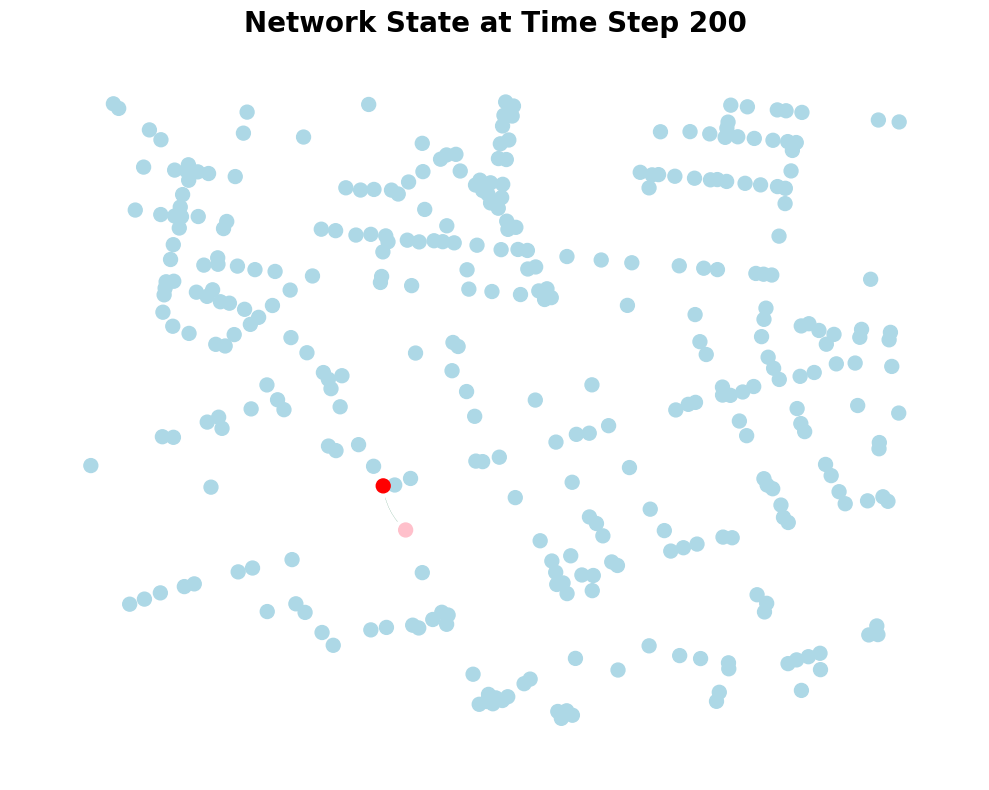

In [2]:
visualizer = NetworkVisualizer(simulation_dir=os.path.join(output_dir, "melbourne"), pos=pos)
# visualizer = NetworkVisualizer(simulation_dir=os.path.join(output_dir, "delft_directions"), pos=pos)
time_step = 200
fig, ax = visualizer.visualize_network_state(time_step=time_step, edge_property='density', with_colorbar=False)

In [15]:
sensor_node_df[sensor_node_df["sensor_id"] == 133]

NameError: name 'sensor_node_df' is not defined

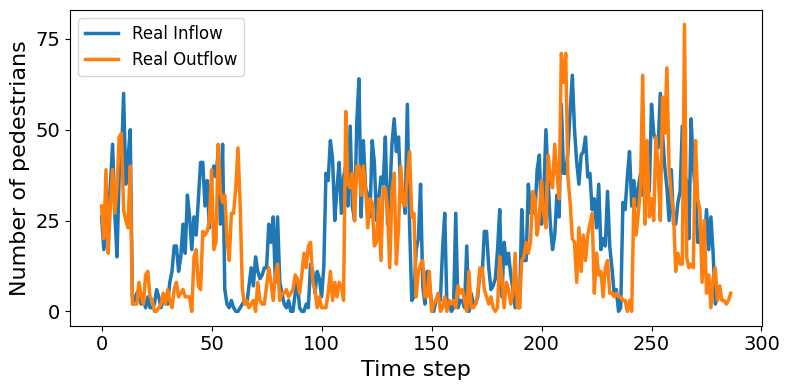

In [79]:
# plot the time-series count of one sensor's one direction
import matplotlib.pyplot as plt
import numpy as np
s_id1 = 133
s_id2 = 135
# Plot the time-series count of one sensor's one direction
# plt.figure(figsize=(10, 5))
y = data[data["Location_ID"] == s_id1]["Direction_1"]
y2 = data[data["Location_ID"] == s_id2]["Direction_1"]
x = np.arange(len(y))
x2 = np.arange(len(y2))
# plt.plot(x, y, label=sensor_location[sensor_location["Location_ID"] == s_id1]["Direction_2"])
# plt.plot(x2, y2, label=sensor_location[sensor_location["Location_ID"] == s_id2]["Direction_2"])
# plt.xlabel("Time")
# # plt.ylabel(f"sensor ID: {s_id}")
# plt.legend()
# plt.show()
plt.figure(figsize=(8, 4))
plt.plot(x, y, label=f'Real Inflow', linewidth=2.5)
plt.plot(x2, y2, label=f'Real Outflow', linewidth=2.5)
plt.xlabel('Time step', fontsize=16)
plt.ylabel('Number of pedestrians', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.locator_params(axis='y', nbins=4)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.show()
# save the figure
plt.savefig('fig/melbourne_real.pdf', format='pdf')


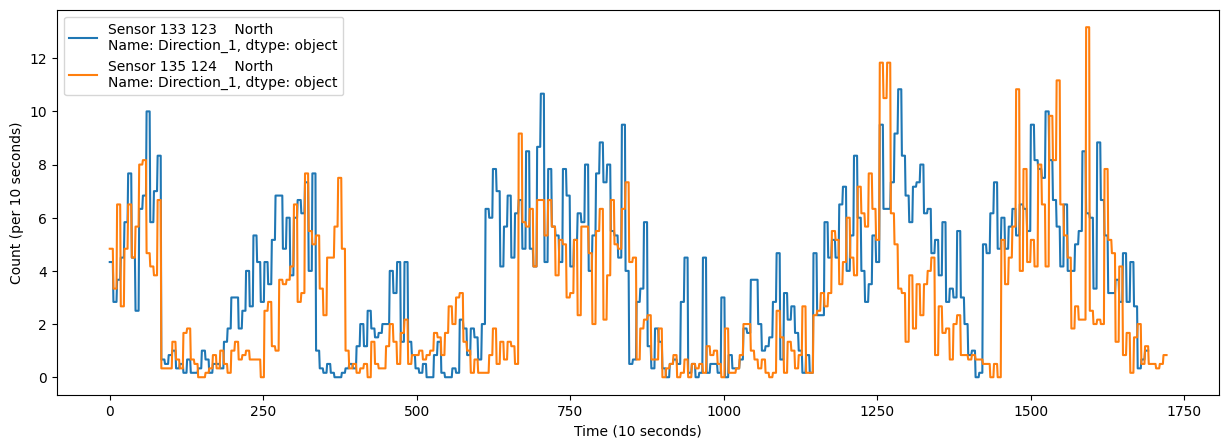

In [51]:
# Convert minute counts to 10-second intervals (divide counts evenly)
def expand_to_10sec(minute_counts):
    return np.repeat(minute_counts/6, 6)  # divide by 6 for even distribution

# Expand the data
s_id1, s_id2 = 133, 135
y1_expanded = expand_to_10sec(data[data["Location_ID"] == s_id1]["Direction_1"])
y2_expanded = expand_to_10sec(data[data["Location_ID"] == s_id2]["Direction_1"])

# Plot expanded time series
plt.figure(figsize=(15, 5))
x_expanded = np.arange(len(y1_expanded))
x2_expanded = np.arange(len(y2_expanded))
plt.plot(x_expanded, y1_expanded, label=f'Sensor {s_id1} {sensor_location[sensor_location["Location_ID"] == s_id1]["Direction_1"]}')
plt.plot(x2_expanded, y2_expanded, label=f'Sensor {s_id2} {sensor_location[sensor_location["Location_ID"] == s_id2]["Direction_1"]}')
plt.xlabel("Time (10 seconds)")
plt.ylabel("Count (per 10 seconds)")
plt.legend()
plt.show()

In [64]:
import json
import os
with open("./outputs/melbourne/link_data.json", 'r') as f:
    link_data = json.load(f)
with open("./outputs/melbourne/node_data.json", 'r') as f:
    node_data = json.load(f)

In [65]:
np.sum(np.array(link_data["265-263"]["inflow"]))

0.0

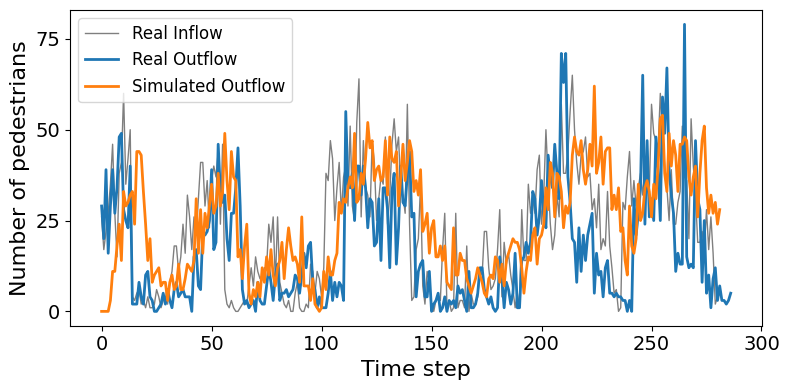

In [86]:
agg_inflow = np.array(link_data["265-286"]["inflow"]).reshape(-1, 6).sum(axis=1)
agg_outflow = np.array(link_data["265-286"]["outflow"]).reshape(-1, 6).sum(axis=1)
plt.figure(figsize=(8, 4))
# plt.plot(agg_inflow, label=f'Real Inflow', linewidth=2.5)
plt.plot(x, y, label=f'Real Inflow', linewidth=1, alpha=0.5, color='black')
plt.plot(x2, y2, label=f'Real Outflow', linewidth=2)
plt.plot(agg_outflow, label=f'Simulated Outflow', linewidth=2)
plt.xlabel('Time step', fontsize=16)
plt.ylabel('Number of pedestrians', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.locator_params(axis='y', nbins=4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('fig/melbourne_simulation.pdf', format='pdf')

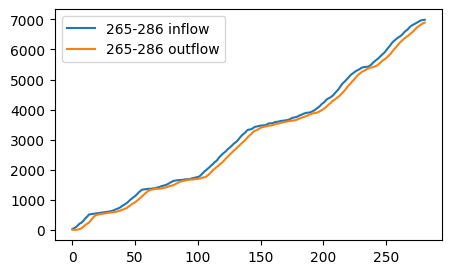

In [16]:
# cumulative sum
plt.figure(figsize=(5,3))
plt.plot(np.cumsum(agg_inflow), label=f'265-286 inflow')
plt.plot(np.cumsum(agg_outflow), label=f'265-286 outflow')
plt.legend()
plt.show()


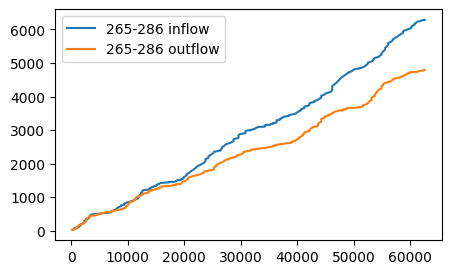

In [16]:
plt.figure(figsize=(5, 3))
plt.plot(np.cumsum(y), label=f'265-286 inflow')
plt.plot(np.cumsum(y2), label=f'265-286 outflow')
plt.legend()
plt.show()